<a href="https://colab.research.google.com/github/GarethWilhelm/TS-Feature-Clustering/blob/Feature-clustering-ZAF/1a.%20clustering_tsfresh_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configs

## Required packages

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
fatal: destination path 'automations' already exists and is not an empty directory.
Already up to date.


In [2]:
# !pip install -q oec
# import oec
!pip install -U -q yellowbrick
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

## Load data

## Data processing

### Lists

In [3]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_','index_mass_quantile','__attr_intercept','__attr_stderr',
                      'sum_values','sum_values','has_duplicate','length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_','energy_ratio_by_chunks',
                      'variance_larger_than_standard_deviation','__lag_0','fourier_entropy','friedrich_coefficients','bins_100','correlation']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values','maximum','length','minimum', 'lag', 'peaks', 'location', 'lempel', 'autolag', 'coefficients']
stats = ['kurtosis','^median$','linear_trend', 'standard_deviation', 'skewness', 'period']
stationarity = ['augmented','entropy','energy','komolgorov','ar_coefficient','sample']

### Data preparation

In [22]:
experiment = "stationary_entropy"
PATH = '/content/drive/My Drive/Stellenbosch/Gareth/sitc/year_origin_sitc_rev2.tsv'
all_eff_features = pd.read_csv(f'{PATH}/zaf_features_extracted.csv')\
 .rename(columns = {'Unnamed: 0': 'product_code'}, inplace = False)
all_eff_features.set_index('product_code',inplace=True)


0      1110
1      1121
2      1122
3      1123
4      1124
       ... 
674    9310
675    9410
676    9510
677    9610
678    9710
Name: product_code, Length: 679, dtype: object

In [ ]:
features_filtered = change_column_prefix(
     remove_features_df(all_eff_features,filter_features(all_eff_features,redundant_features)))
features_filtered.columns

# Run the ETL

In [11]:
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df.columns

Index(['augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"',
       'augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"',
       'augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"',
       'binned_entropy__max_bins_10',
       'permutation_entropy__dimension_3__tau_1',
       'permutation_entropy__dimension_4__tau_1',
       'permutation_entropy__dimension_5__tau_1',
       'permutation_entropy__dimension_6__tau_1',
       'permutation_entropy__dimension_7__tau_1', 'abs_energy',
       'ar_coefficient__coeff_0__k_10', 'ar_coefficient__coeff_1__k_10',
       'ar_coefficient__coeff_2__k_10', 'ar_coefficient__coeff_3__k_10',
       'ar_coefficient__coeff_4__k_10', 'ar_coefficient__coeff_5__k_10',
       'ar_coefficient__coeff_6__k_10', 'ar_coefficient__coeff_7__k_10',
       'ar_coefficient__coeff_8__k_10', 'ar_coefficient__coeff_9__k_10',
       'ar_coefficient__coeff_10__k_10'],
      dtype='object')

In [12]:
# stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.columns = (stationary_features_df.columns.str.strip().\
                                  str.replace('__tau_1','').\
                                  str.replace('coefficient__','').\
                                  str.replace('complexity__','').\
                                  str.replace('__k_10','').\
                                  str.replace('__max_bins_10','').\
                                  str.replace('__autolag','')
                                  )
simplify_column_name(stationary_features_df,'permutation_entropy__dimension','permutation_entropy')
clean_header(stationary_features_df)
# Drop correlated features (threshold: 0.5)
stationary_features_df = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
stationary_features_df.columns

Index(['adf_pvalue_aic', 'binned_entropy', 'permutation_entropy_7',
       'abs_energy', 'ar_coeff_0', 'ar_coeff_1', 'ar_coeff_2', 'ar_coeff_3',
       'ar_coeff_4', 'ar_coeff_5', 'ar_coeff_6', 'ar_coeff_7', 'ar_coeff_8',
       'ar_coeff_9'],
      dtype='object')

In [13]:
stationary_features_df = remove_outliers_iqr(stationary_features_df)
stationary_features_df.reset_index() 

,product_code,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,ar_coeff_0,ar_coeff_1,ar_coeff_2,ar_coeff_3,ar_coeff_4,ar_coeff_5,ar_coeff_6,ar_coeff_7,ar_coeff_8,ar_coeff_9
0,1110,1.000000e+00,1.593259,3.671008,1.579678e+17,2.233392e+06,0.740492,-0.112170,-0.054857,0.149816,0.279991,-0.353105,0.350096,0.387702,-0.719641
1,1121,1.450275e-08,1.478919,3.640176,7.569204e+18,1.783835e+06,1.548634,-0.757613,1.144176,-1.673298,1.760263,-0.922674,-0.408033,1.616305,-2.403165
2,1122,2.623506e-01,1.213138,3.564623,4.999832e+16,1.380799e+06,0.583699,0.818690,-0.010051,-1.078805,0.367499,-1.220418,2.150526,2.237032,3.553266
3,1123,4.287288e-01,1.673611,3.813439,5.016715e+16,3.012926e+06,0.548623,0.271674,0.271975,-0.334659,0.070103,-0.290454,0.170541,0.415989,0.173922
4,1124,1.000000e+00,1.322301,3.556418,2.079230e+17,8.936876e+05,0.732097,-0.152980,0.006669,-0.391492,0.148742,-0.128432,3.119787,-0.934865,-0.278937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,9310,9.485747e-05,0.677842,3.773394,4.114501e+20,4.934374e+08,0.048261,-0.043722,0.163337,0.144698,0.145263,0.137698,0.211816,0.045566,0.131942
675,9410,9.769099e-01,1.564279,3.828845,4.025901e+15,4.541063e+05,0.651171,0.894523,-0.587213,0.520550,-1.302612,0.895208,-0.650420,1.045265,-1.102690
676,9510,1.000000e+00,1.076744,3.891820,2.829096e+17,5.280314e+06,0.927558,-0.498891,-0.131603,-0.003952,0.187051,-0.711976,1.173702,0.681707,0.303379
677,9610,3.618532e-03,0.945308,3.683436,4.284234e+15,4.199039e+06,0.732951,-0.503404,0.433710,-0.503304,0.403029,-0.524605,0.450840,-0.412861,0.211708


In [14]:
# Add statistical features to dataframe
stats_features_df = features_filtered[filter_features(features_filtered,stats)]
stats_features_df = remove_outliers_iqr(stats_features_df)
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('__autolag_aic', ''))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('kurtosis', 'kurtosis'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('median','median'))
stats_features_df = stats_features_df.rename(columns = lambda x: x.replace('linear_trend__attr', 'trend'))
stats_features_df.reset_index() 

,product_code,kurtosis,median,"trend_""pvalue""","trend_""rvalue""","trend_""intercept""","trend_""slope""","trend_""stderr""",standard_deviation,skewness
0,1110,1.545686,3.564000e+06,3.315796e-16,0.847602,-2.967426e+07,2.289611e+06,1.968909e+05,4.288151e+07,1.488710
1,1121,-0.506985,1.456416e+07,4.056517e-14,0.809942,-1.936363e+08,1.490191e+07,1.468473e+06,2.973828e+08,1.086157
2,1122,2.235449,9.031385e+05,1.904704e-08,0.729790,-1.972867e+07,1.687599e+06,2.439459e+05,2.936439e+07,1.864961
3,1123,-0.325437,2.504446e+06,4.494836e-12,0.777921,-1.272169e+07,1.193398e+06,1.336773e+05,2.390992e+07,1.011084
4,1124,2.275437,3.961318e+06,3.336319e-12,0.771790,-3.528286e+07,2.462820e+06,2.761275e+05,5.157764e+07,1.833505
...,...,...,...,...,...,...,...,...,...,...
674,9310,15.983471,1.543661e+08,2.051275e-03,0.403384,-5.913921e+08,6.175184e+07,1.906206e+07,2.474339e+09,3.832982
675,9410,2.420401,2.162300e+06,1.586659e-13,0.798972,-3.428896e+06,3.220274e+05,3.298409e+04,6.514623e+06,1.685828
676,9510,7.587690,3.965538e+06,1.686853e-08,0.674095,-3.637840e+07,2.652538e+06,3.992434e+05,6.246555e+07,2.659331
677,9610,8.611174,4.371730e+05,2.961316e-01,0.149174,1.920348e+06,8.353065e+04,7.909844e+04,8.242306e+06,2.903055


In [15]:
# Merge stationarity and statistical features
features_uncorrelated = pd.merge(stationary_features_df,stats_features_df,on='product_code')
clean_header(features_uncorrelated)

,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,ar_coeff_0,ar_coeff_1,ar_coeff_2,ar_coeff_3,ar_coeff_4,ar_coeff_5,ar_coeff_6,ar_coeff_7,ar_coeff_8,ar_coeff_9,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
product_code,,,,,,,,,,,,,,,,,,,,,,,
1110,1.000000e+00,1.593259,3.671008,1.579678e+17,2.233392e+06,0.740492,-0.112170,-0.054857,0.149816,0.279991,-0.353105,0.350096,0.387702,-0.719641,1.545686,3.564000e+06,3.315796e-16,0.847602,-2.967426e+07,2.289611e+06,1.968909e+05,4.288151e+07,1.488710
1121,1.450275e-08,1.478919,3.640176,7.569204e+18,1.783835e+06,1.548634,-0.757613,1.144176,-1.673298,1.760263,-0.922674,-0.408033,1.616305,-2.403165,-0.506985,1.456416e+07,4.056517e-14,0.809942,-1.936363e+08,1.490191e+07,1.468473e+06,2.973828e+08,1.086157
1122,2.623506e-01,1.213138,3.564623,4.999832e+16,1.380799e+06,0.583699,0.818690,-0.010051,-1.078805,0.367499,-1.220418,2.150526,2.237032,3.553266,2.235449,9.031385e+05,1.904704e-08,0.729790,-1.972867e+07,1.687599e+06,2.439459e+05,2.936439e+07,1.864961
1123,4.287288e-01,1.673611,3.813439,5.016715e+16,3.012926e+06,0.548623,0.271674,0.271975,-0.334659,0.070103,-0.290454,0.170541,0.415989,0.173922,-0.325437,2.504446e+06,4.494836e-12,0.777921,-1.272169e+07,1.193398e+06,1.336773e+05,2.390992e+07,1.011084
1124,1.000000e+00,1.322301,3.556418,2.079230e+17,8.936876e+05,0.732097,-0.152980,0.006669,-0.391492,0.148742,-0.128432,3.119787,-0.934865,-0.278937,2.275437,3.961318e+06,3.336319e-12,0.771790,-3.528286e+07,2.462820e+06,2.761275e+05,5.157764e+07,1.833505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9310,9.485747e-05,0.677842,3.773394,4.114501e+20,4.934374e+08,0.048261,-0.043722,0.163337,0.144698,0.145263,0.137698,0.211816,0.045566,0.131942,15.983471,1.543661e+08,2.051275e-03,0.403384,-5.913921e+08,6.175184e+07,1.906206e+07,2.474339e+09,3.832982
9410,9.769099e-01,1.564279,3.828845,4.025901e+15,4.541063e+05,0.651171,0.894523,-0.587213,0.520550,-1.302612,0.895208,-0.650420,1.045265,-1.102690,2.420401,2.162300e+06,1.586659e-13,0.798972,-3.428896e+06,3.220274e+05,3.298409e+04,6.514623e+06,1.685828
9510,1.000000e+00,1.076744,3.891820,2.829096e+17,5.280314e+06,0.927558,-0.498891,-0.131603,-0.003952,0.187051,-0.711976,1.173702,0.681707,0.303379,7.587690,3.965538e+06,1.686853e-08,0.674095,-3.637840e+07,2.652538e+06,3.992434e+05,6.246555e+07,2.659331


In [16]:
features_uncorrelated.fillna(0,inplace=True)
features_uncorrelated.isnull().sum()

adf_pvalue_aic           0
binned_entropy           0
permutation_entropy_7    0
abs_energy               0
ar_coeff_0               0
ar_coeff_1               0
ar_coeff_2               0
ar_coeff_3               0
ar_coeff_4               0
ar_coeff_5               0
ar_coeff_6               0
ar_coeff_7               0
ar_coeff_8               0
ar_coeff_9               0
kurtosis                 0
median                   0
trend_pvalue             0
trend_rvalue             0
trend_intercept          0
trend_slope              0
trend_stderr             0
standard_deviation       0
skewness                 0
dtype: int64

## EDA and correlation analysis

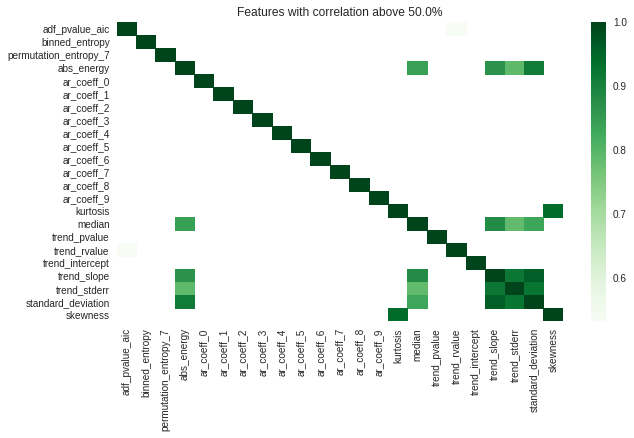

In [17]:
image_dump = f"{PATH}/images"
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{image_dump}/_correlation_{experiment}")
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series

# Clustering

## PCA + k-Means

* Scale features using Standard Scaler
* Dimension reduction to 2 PCs
* Locate optimum number of cluster

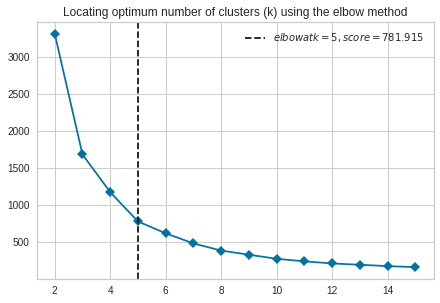

In [18]:
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)
product_name = 'all_products'
# Reduce dimensions using PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)

# Optimum clusters
# plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),15)
kelbow_visualizer = KElbowVisualizer(
    KMeans(random_state=42), k=15,metric='distortion',
    timings=False,locate_elbow=True,size=(512, 340))
kelbow_visualizer.fit(np.asarray(PCA_components))
pca_k_value = kelbow_visualizer.elbow_value_
plt.title('Locating optimum number of clusters (k) using the elbow method')
plt.legend()
plt.savefig(f"{image_dump}/{experiment}_elbow")

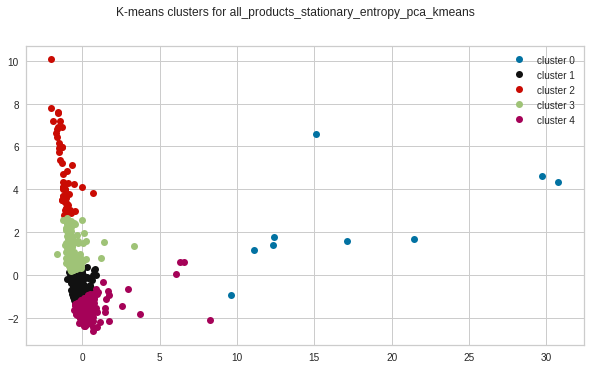

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   names    679 non-null    int64
 1   cluster  679 non-null    int64
dtypes: int64(2)
memory usage: 10.7 KB


In [19]:
clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),pca_k_value,f"{product_name}_{experiment}_pca_kmeans",
                                                      f"{image_dump}")



In [26]:
#features_uncorrelated['product_code'].astype(str)
features_uncorrelated.index

Int64Index([1110, 1121, 1122, 1123, 1124, 1211, 1212, 1213, 1221, 1222,
            ...
            8994, 8996, 8997, 8998, 8999, 9310, 9410, 9510, 9610, 9710],
           dtype='int64', name='product_code', length=679)

In [46]:
details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'product_code':'names'})
get_names.names.astype('str')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
country_cluster.head()

,names,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,ar_coeff_0,ar_coeff_1,ar_coeff_2,ar_coeff_3,ar_coeff_4,ar_coeff_5,ar_coeff_6,ar_coeff_7,ar_coeff_8,ar_coeff_9,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness,cluster
0,1110,1.167889,0.139962,0.250459,-0.099046,-0.103578,0.434954,-0.331524,-0.401411,0.659110,0.371277,-0.387230,0.130960,0.229633,-0.584458,-0.300170,-0.158196,-0.31093,0.744495,-0.079990,-0.048748,-0.106759,-0.048799,-0.138332,1
1,1121,-1.335153,-0.140358,0.136976,0.033707,-0.110556,2.577443,-2.002469,2.515385,-3.653647,3.546661,-1.323400,-0.681139,1.361884,-2.074151,-0.600818,-0.074545,-0.31093,0.621667,-1.489870,0.855027,0.524674,0.948432,-0.506231,4
2,1122,-0.678478,-0.791956,-0.141101,-0.100980,-0.116812,0.019273,2.078318,-0.292416,-2.247314,0.558994,-1.812785,2.059560,1.933931,3.196488,-0.199142,-0.178430,-0.31093,0.360250,0.005530,-0.091887,-0.083393,-0.101764,0.205528,1
3,1123,-0.262027,0.336955,0.774685,-0.100977,-0.091478,-0.073716,0.662186,0.393648,-0.486964,-0.078962,-0.284254,-0.061378,0.255701,0.206224,-0.574228,-0.166253,-0.31093,0.517230,0.065782,-0.127301,-0.138149,-0.123137,-0.574841,1
4,1124,1.167889,-0.524328,-0.171301,-0.098151,-0.124372,0.412698,-0.437173,-0.251741,-0.621408,0.089730,-0.017946,3.097821,-0.989214,-0.194495,-0.193286,-0.155174,-0.31093,0.497233,-0.128217,-0.036336,-0.067413,-0.014725,0.176781,1


In [47]:
country_cluster.drop('names', axis=1, inplace=True)

In [48]:
groups = country_cluster.groupby(['cluster']).agg('mean')


In [50]:
#clust = groups.reset_index()
dict_clust = {0:'cluster_0',
              1: 'cluster_1',
              2: 'cluster_2',
              3: 'cluster_3',
              4: 'cluster_4',
              5: 'cluster_5'
              }
clust = groups.reset_index()
clust.replace({'cluster': dict_clust},inplace=True)
clust.set_index('cluster',inplace=True)
# x = clust.iloc[-1,:]
clust

,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,ar_coeff_0,ar_coeff_1,ar_coeff_2,ar_coeff_3,ar_coeff_4,ar_coeff_5,ar_coeff_6,ar_coeff_7,ar_coeff_8,ar_coeff_9,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,standard_deviation,skewness
cluster,,,,,,,,,,,,,,,,,,,,,,,
cluster_0,0.512705,-0.010681,-0.078638,6.802406,4.297435,0.437968,-0.621262,1.073016,-0.572608,0.589334,-0.366544,0.414390,-1.040549,0.025256,-0.079058,6.387292,-0.309518,0.408493,-6.944555,7.522817,7.063744,7.678650,0.039905
cluster_1,0.058960,0.174076,0.266302,-0.100047,-0.071833,0.013450,0.204935,-0.089022,0.028929,-0.081894,0.069980,0.012750,0.039137,-0.018088,-0.317294,-0.124862,-0.262326,0.254792,0.122734,-0.148474,-0.141127,-0.146581,-0.261268
cluster_2,-0.928759,-1.938688,-0.173220,-0.099478,-0.038497,-1.010829,-0.193077,-0.322244,0.082976,-0.356538,0.077939,-0.034204,0.181311,-0.034713,2.465318,-0.165854,1.693210,-1.612466,0.207372,-0.199448,-0.125529,-0.153573,2.283414
cluster_3,-0.370794,-0.543027,0.074481,-0.094574,-0.069483,-0.405439,0.192325,-0.233840,0.279670,-0.061882,0.003882,-0.056247,0.081489,-0.009431,0.344058,-0.123622,0.244631,-0.803486,0.170363,-0.166119,-0.119413,-0.135771,0.536519
cluster_4,0.433643,0.724452,-0.353044,-0.075124,-0.036399,0.546524,-0.322772,0.330160,-0.232641,0.232742,-0.103211,0.013769,-0.116666,0.040007,-0.547381,0.016719,-0.310894,0.681693,-0.033869,0.037103,-0.006771,-0.007240,-0.707441


In [52]:
b = clust.T

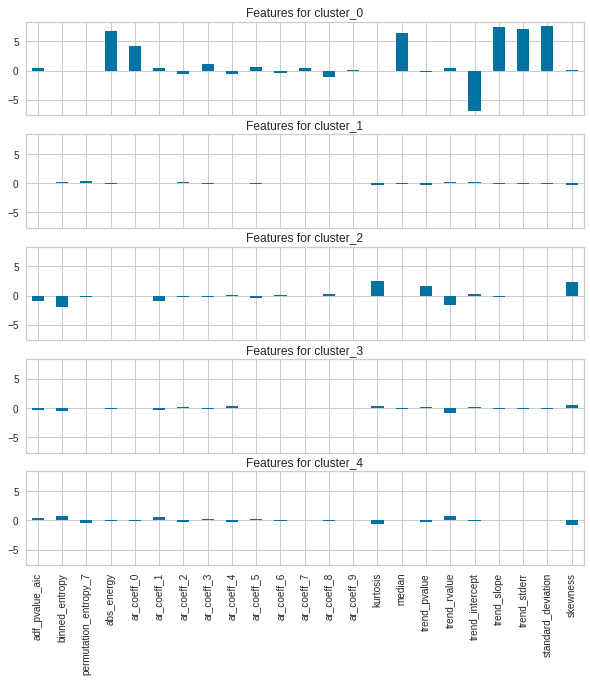

In [54]:
n = len(b.columns)
fig, ax = plt.subplots(n, 1, figsize=(10, n * 2), sharex=True,sharey=True)
for i in range(n):
    plt.sca(ax[i])
    col = b.columns[i]
    b[col].plot(kind='bar')
    plt.title(f"Features for {col}")
    # plt.tight_layout()
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features.png",bbox_inches = "tight")

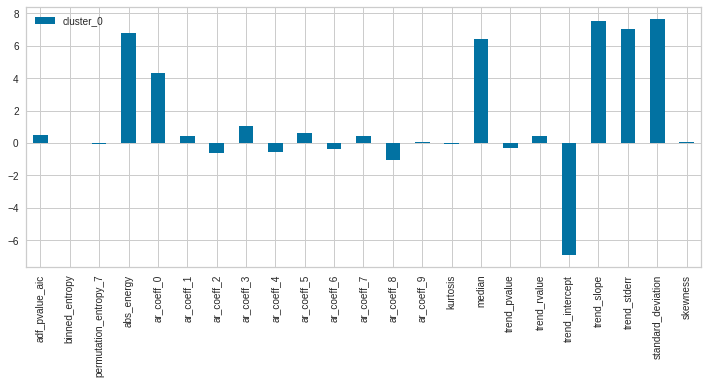

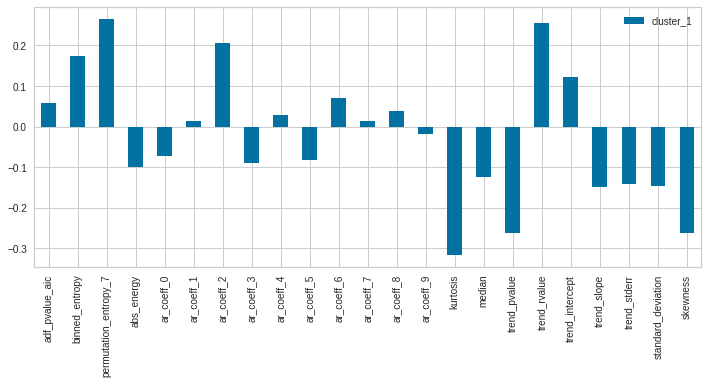

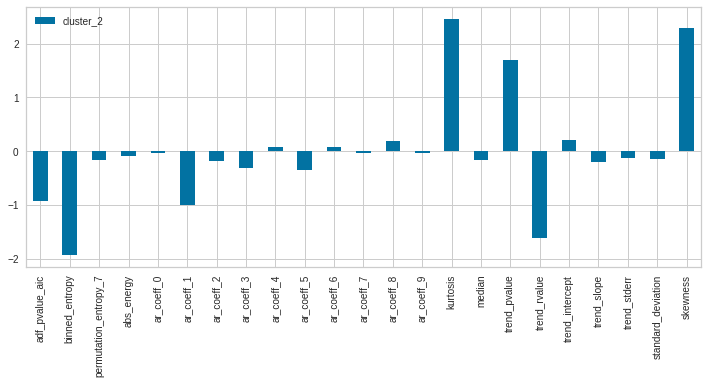

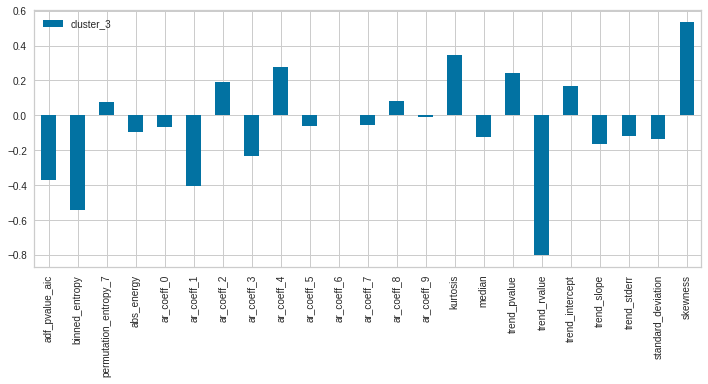

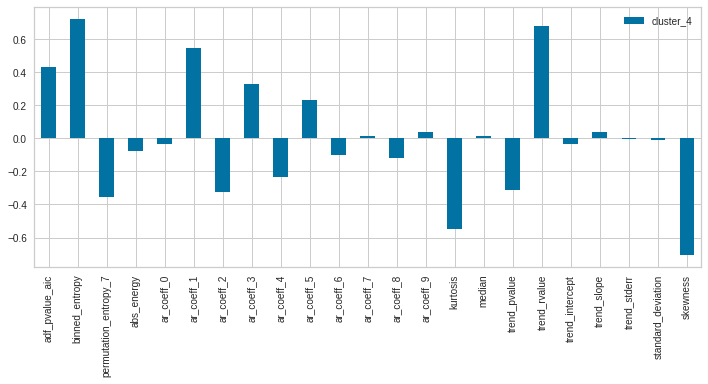

In [53]:
for col in b.columns:
  b[col].plot(kind='bar',figsize=(10,5.5))
  plt.legend()
  plt.tight_layout()
  plt.savefig(f"{image_dump}/{col}_{product_name}_features.png",bbox_inches = "tight")
  plt.show()

In [ ]:
# clusts.shape[0]
ax = clust.plot(figsize=(15,10),kind='bar')
fig = ax.get_figure()
plt.xlabel('Cluster number')
plt.ylabel("Relative value")
plt.legend(loc='best',ncol=3)
plt.title('Characteristic features for different clusters')
fig.savefig(f"{image_dump}/{product_name}_{experiment}_pca_kmeans_features.png")

# Cluster analysis

In [ ]:
trade_dframe = pd.read_csv(f"{PATH}/trade_data_flat_df.csv",
                           usecols=['year','export_val','country','product_name','country_product']
                           )
trade_dframe.head()

,year,export_val,country,product_name,country_product
0,1962,3000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
1,1963,15000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
2,1964,4000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
3,1966,2000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber
4,1967,7000.0,Cote d'Ivoire,yarn_fiber,afciv_yarn_fiber


In [ ]:
country_cluster.head()

,names,auto_corr_lag_1,auto_corr_lag_2,auto_corr_lag_3,pac_lag_1,pac_lag_2,pac_lag_3,adf_teststat_aic,adf_pvalue_aic,binned_entropy,permutation_entropy_7,abs_energy,lempel_ziv_bins_3,lempel_ziv_bins_5,lempel_ziv_bins_10,ar_coeff_1,ar_coeff_2,ar_coeff_3,kurtosis,median,trend_pvalue,trend_rvalue,trend_intercept,trend_slope,trend_stderr,cluster
0,afago_Cars,-0.699309,-0.679260,-0.544710,-0.739400,0.141456,0.009284,0.016423,1.446917,-1.526053,1.038662,-0.049445,-1.204692,-1.546453,-1.909458,0.028511,-0.109969,-0.022255,4.196947,-0.097398,-0.486480,-0.170293,0.092860,-0.031036,-0.102641,4
1,afago_Electrical Resistors,-0.949355,-0.215017,-1.029699,-0.997863,0.932888,-0.714529,0.016423,-0.891944,-0.586474,-0.210139,-0.049449,0.152629,0.100074,-0.306037,-0.058897,0.033928,-0.024509,0.557114,-0.097494,0.728612,-0.434640,0.097811,-0.031327,-0.117015,4
2,afago_Electrical Transformers,-0.609143,-0.585381,-0.266324,-0.646198,0.272417,0.416133,0.016423,1.455414,-1.002113,0.381714,-0.049449,-0.470083,-0.802372,-0.929715,-0.034785,0.033074,-0.024423,1.761422,-0.097492,-0.442996,0.022249,0.097701,-0.031312,-0.116236,4
3,afago_Electronic Microcircuits,-0.413443,-0.786265,-0.569079,-0.443912,-0.175428,0.071169,0.016423,-0.889767,-0.724140,0.337623,-0.049449,0.152629,0.100074,-0.041446,-0.038260,0.038035,-0.024346,1.219203,-0.097492,-0.544405,0.133379,0.097766,-0.031320,-0.116716,4
4,afago_Felt,-0.962178,-0.787885,-0.688000,-1.011118,-0.028266,-0.231626,0.016423,-0.891927,-1.431544,-1.529407,-0.049449,-0.987413,-1.326373,-1.695139,-0.039787,0.036716,-0.024461,2.011648,-0.097494,0.931789,-0.493211,0.097811,-0.031327,-0.117017,4


<Figure size 720x396 with 0 Axes>

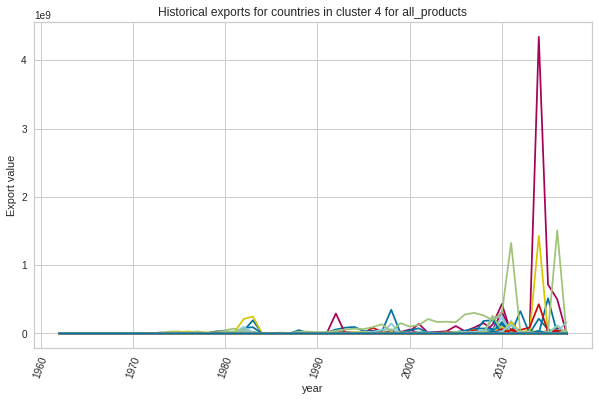

<Figure size 720x396 with 0 Axes>

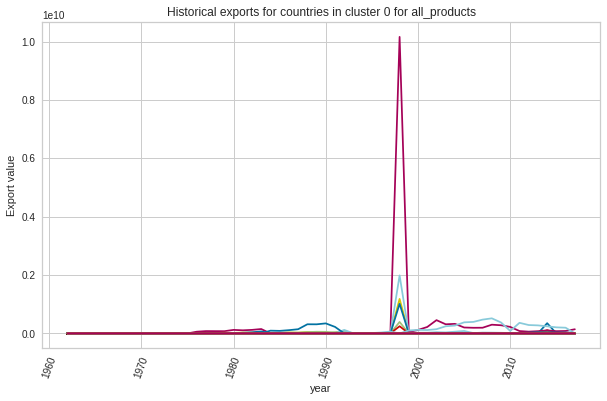

<Figure size 720x396 with 0 Axes>

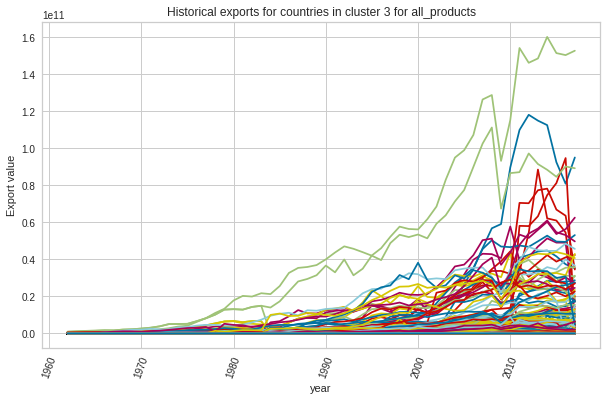

<Figure size 720x396 with 0 Axes>

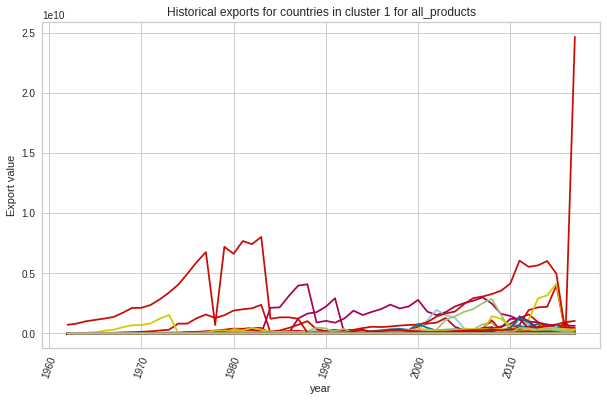

<Figure size 720x396 with 0 Axes>

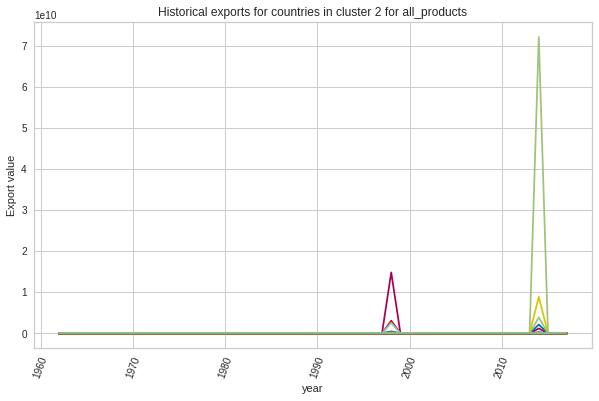

In [ ]:
# Plots for country comparison per product 
for c in country_cluster.cluster.unique():
  cluster = country_cluster[country_cluster.cluster==c]
  country_list = cluster['names'].unique()
  product = pd.pivot_table(trade_dframe,index='year',columns='country_product',
                           values='export_val',aggfunc=np.mean)
  df = product[country_list]
  df.fillna(0,inplace=True)
  plt.figure(figsize=(10,5.5))
  df.plot(subplots=False,figsize=(10,6),legend=False,
                            title=(f"Historical exports for countries in cluster {c} for {product_name}"))
  plt.xticks(rotation=70)
  # plt.legend()
  plt.ylabel("Export value")
  plt.savefig(f"{image_dump}/{product_name}_cluster_{c}")
  plt.show()